Modelo considerando dados de empresa de consumo de varejo.

[Fonte:Storopoli](https://storopoli.github.io/Bayesian-Julia/pages/10_robust_reg/)

In [1]:
# Pacotes necessários
import Pkg
#Pkg.add("StatsPlots")
#Pkg.add("Distributions")
#Pkg.add("LaTeXStrings")
#Pkg.add("DataFrames")

In [2]:
# Carregar pacotes
using StatsPlots, Distributions, LaTeXStrings, DataFrames

In [3]:
# Plots Densidade
#plot(Normal(0, 1), lw=5, label=false, xlabel=L"x", ylabel="Density")
#plot(TDist(2), lw=5, label=false, xlabel=L"x", ylabel="Density", xlims=(-4, 4))

# Normal vs Student-t
#plot(Normal(0, 1), lw=5, label="Normal", xlabel=L"x", ylabel="Density", xlims=(-4, 4))
#plot!(TDist(2), lw=5, label="Student")

# Bayesian Robust Regression

In [4]:
# Instalar pacotes necessários
#Pkg.add("Turing")
#Pkg.add("StatsBase")

In [5]:
# Carregar pacotes
using Turing
using Statistics: mean, std
using StatsBase: mad
using Random: seed!

In [6]:
# Travar seed
seed!(123)

Random.TaskLocalRNG()

In [7]:
# Modelo
@model function robustreg(X, y; predictors=size(X, 2))
        #priors
        α ~ LocationScale(median(y), 2.5 * mad(y), TDist(3))
        β ~ filldist(TDist(3), predictors)
        σ ~ Exponential(1)
        ν ~ LogNormal(2, 1)

        #likelihood
        y ~ arraydist(LocationScale.(α .+ X * β, σ, TDist.(ν)))
end;

In [8]:
# Carregar base
using DataFrames, CSV, HTTP

url = "https://raw.githubusercontent.com/andrelmfsantos/df/main/dataset_roi.csv"
data = CSV.read(HTTP.get(url).body, DataFrame)
describe(data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,OBS,94.1016,1,94.0,188,0,Int64
2,Ano,2021.58,2021,2022.0,2022,0,Int64
3,TRIMESTRE,,T1,,T4,0,String3
4,MARCA,,Marca1,,Marca6,0,String7
5,ORIGEM,,Origem1,,Origem7,0,String7
6,OBJETIVO,,Objetivo1,,Objetivo9,0,String15
7,LL,2.37397e7,5362,6.38324e6,117622653,148,"Union{Missing, Int64}"
8,P1,3.29733e7,1155,1.1306e7,262588743,103,"Union{Missing, Int64}"
9,P2,6.65926e7,190,1.94569e7,659234391,50,"Union{Missing, Int64}"


In [9]:
# Subset
df = data[!, names(data,[:MARCA,:LL,:P1,:P2,:P3,:INVESTIMENTO,:LUCRO, :ROI])]

,MARCA,LL,P1,P2,P3,INVESTIMENTO,LUCRO,ROI
,String7,Int64?,Int64?,Int64?,Int64?,Float64,Float64,Float64
1,Marca1,missing,9479281,239975,39700837,38770.2,41339.3,1.07
2,Marca1,missing,33459865,478635,71974878,61362.9,75183.4,1.23
3,Marca1,missing,missing,missing,39251146,69688.1,47008.6,0.67
4,Marca2,missing,4344180,missing,101037504,97638.1,1.74764e5,1.79
5,Marca2,missing,11056932,missing,424764281,2.93678e5,4.31466e5,1.47
6,Marca2,missing,160738,missing,132502984,1.86986e5,1.4422e5,0.77
7,Marca3,missing,missing,missing,4505070,11538.6,15798.0,1.37
8,Marca3,missing,missing,missing,2547734,22948.9,41048.3,1.79
9,Marca3,missing,18156818,52964982,73533227,1.38559e5,2.76154e5,1.99


In [10]:
# Replace missing data
for col in eachcol(df)
    replace!(col,missing => 0)
end

In [11]:
# Converter colunas para inteiro
df[!,:LL] = map(Int64, df[!,:LL])
df[!,:P1] = map(Int64, df[!,:P1])
df[!,:P2] = map(Int64, df[!,:P2])
df[!,:P3] = map(Int64, df[!,:P3])
first(df,5)

,MARCA,LL,P1,P2,P3,INVESTIMENTO,LUCRO,ROI
,String7,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,Marca1,0,9479281,239975,39700837,38770.2,41339.3,1.07
2,Marca1,0,33459865,478635,71974878,61362.9,75183.4,1.23
3,Marca1,0,0,0,39251146,69688.1,47008.6,0.67
4,Marca2,0,4344180,0,101037504,97638.1,1.74764e5,1.79
5,Marca2,0,11056932,0,424764281,2.93678e5,4.31466e5,1.47


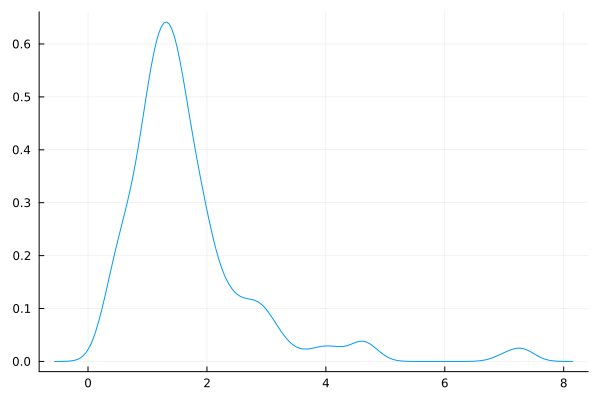

In [12]:
# Densidade
@df df density(:ROI, label=false)

In [13]:
# Agrupar
# https://stackoverflow.com/questions/64226866/groupby-with-sum-on-julia-dataframe
numcols = names(df, findall(x -> eltype(x) <: Number, eachcol(df)))
gdf = combine(groupby(df, ["MARCA"]), numcols .=> sum .=> numcols)

,MARCA,LL,P1,P2,P3,INVESTIMENTO,LUCRO
,String7,Int64,Int64,Int64,Int64,Float64,Float64
1,Marca1,80434716,50767710,278946893,171927027,430990.0,4.68337e5
2,Marca2,105447286,782072034,2666458850,1002052999,3.8777e6,5.05583e6
3,Marca3,80272502,392144882,1818709665,1793846641,4.42409e6,5.1853e6
4,Marca4,343149133,850488159,1872531856,770155964,2.73943e6,3.86883e6
5,Marca5,200658657,306432902,1550606003,449975388,2.09902e6,3.50322e6
6,Marca6,115886057,387847667,935932395,429239725,1.95436e6,4.51849e6


In [14]:
# Coluna calculada (ROI)
roi = gdf[!,:LUCRO]./gdf[!,:INVESTIMENTO]
gdf.ROI = roi
show(gdf, allcols=true)

6×8 DataFrame
 Row │ MARCA    LL         P1         P2          P3          INVESTIMENTO    LUCRO      ROI     
     │ String7  Int64      Int64      Int64       Int64       Float64         Float64    Float64 
─────┼───────────────────────────────────────────────────────────────────────────────────────────
   1 │ Marca1    80434716   50767710   278946893   171927027  430990.0        4.68337e5  1.08665
   2 │ Marca2   105447286  782072034  2666458850  1002052999       3.8777e6   5.05583e6  1.30382
   3 │ Marca3    80272502  392144882  1818709665  1793846641       4.42409e6  5.1853e6   1.17206
   4 │ Marca4   343149133  850488159  1872531856   770155964       2.73943e6  3.86883e6  1.41227
   5 │ Marca5   200658657  306432902  1550606003   449975388       2.09902e6  3.50322e6  1.66898
   6 │ Marca6   115886057  387847667   935932395   429239725       1.95436e6  4.51849e6  2.312

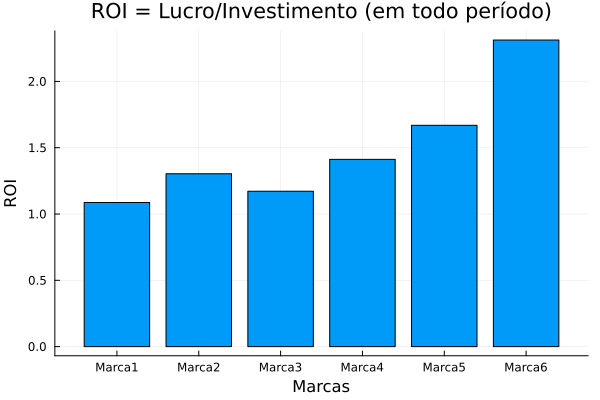

In [15]:
#Pkg.add("Plots")
using Plots
Xs = gdf[!,:MARCA]
Ys = gdf[!,:ROI]
p = bar(Xs,Ys, label=false)
ylabel!("ROI")
xlabel!("Marcas")
title!("ROI = Lucro/Investimento (em todo período)")
#savefig(p,"barplot.png")

In [16]:
# Instanciar os dados
X = Matrix(select(df, [:LL, :P1, :P2, :P3]))
y = df[:, :ROI]
model = robustreg(X, y);

In [21]:
# Cadeias de Markov
chain = sample(model, NUTS(), MCMCThreads(), 1_000, 4)
#summarystats(chain)
#show(summarystats(chain), allcols=true)
DataFrame(summarystats(chain))

,parameters,mean,std,naive_se,mcse,ess,rhat,ess_per_sec
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,α,-0.39103,1.08262,0.0171178,0.135931,8.01603,80780.2,0.0136974
2,β[1],0.226125,0.774273,0.0122423,0.0969941,8.01603,61108.7,0.0136974
3,β[2],-0.382241,0.638317,0.0100927,0.0805193,8.01603,23475.1,0.0136974
4,β[3],-0.363344,0.619492,0.00979503,0.0785029,8.01603,1.49229e5,0.0136974
5,β[4],-0.939354,0.840316,0.0132866,0.105493,8.01603,57234.7,0.0136974
6,σ,1.87421,1.57505,0.0249038,0.198265,8.01603,57955.4,0.0136974
7,ν,0.134418,0.135989,0.00215017,0.0169579,8.01603,26411.0,0.0136974


In [22]:
# Quartiles
quantile(chain)

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           α   -1.5399   -1.3996   -0.5082    0.5004    0.9921
        β[1]   -0.9850   -0.0397    0.3632    0.6291    1.1630
        β[2]   -1.0674   -0.9619   -0.4632    0.1167    0.4645
        β[3]   -1.4361   -0.3720   -0.0086    0.0000    0.0000
        β[4]   -2.2187   -1.3952   -0.7694   -0.3135    0.0000
           σ    0.4800    0.5164    1.3371    2.6951    4.3425
           ν    0.0471    0.0542    0.0605    0.1406    0.3697
